# Binary input RBM

RBM (Restricted Boltzmann Machine)

* input으로부터 feature를 생성하기 위해 deep belief network에서 RBM과 autoencoder 사용.
* 입력 집합에 대한 확률 분포를 학습할 수 있는 생성적 확률적 인공신경망.
* RBM은 input layer와 hidden layer 각 1개로 구성됨.

Contrastive divergence (CD)

* CD는 Hinton이 제안. Gibbs 표본추출법을 이용하는 RBM의 간단한 학습법. 
* CD-k : k번째 단계를 사용하는 CD.
* RBM을 쌓으면 다층 RBM이 되는 것이 아니라 DBN과 비슷해진다는 사실을 발견. 이는 DBN학습을 단순히 여러 개의 RBM 학습으로 환원시킴으로써 어려운 DBN 학습의 복잡도를 층의 개수에 비례하는 복잡도로 낮추었다.

참조 - `내 맘대로 이해하는 DBN과 RBM` (https://www.whydsp.org/283)

### MNIST 데이터에 binary RBM 적용

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

%matplotlib inline
import matplotlib.pyplot as plt

from tensorflow.examples.tutorials.mnist import input_data

In [2]:
# Load data
mnist = input_data.read_data_sets("../temp/MNIST_data", one_hot=True)  # label = one hot.

mnist.train.num_examples

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../temp/MNIST_data\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../temp/MNIST_data\train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ../temp/MNIST_data\t10k-images-idx3-ubyte.gz
Extracting ../temp/MNIST_data\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


55000

In [3]:
# 학습관련 매개변수 설정

n_input      = 784
n_hidden     = 500
display_step = 10
num_epochs   = 100
batch_size   = 256 
lr           = tf.constant(0.001, tf.float32)

In [4]:
# 입력, 가중치 및 편향 정의

x   = tf.placeholder(tf.float32, [None, n_input], name="x")

W   = tf.Variable(tf.random_normal([n_input, n_hidden], 0.01), name="W")
b_h = tf.Variable(tf.zeros([1, n_hidden],  tf.float32, name="b_h"))
b_i = tf.Variable(tf.zeros([1, n_input],  tf.float32, name="b_i"))

In [5]:
# 확률을 이산 상태, 즉 0과 1로 변환
def binary(probs):
    return tf.floor(probs + tf.random_uniform(tf.shape(probs), 0, 1))
          
# 단계별 Gibbs 표본추출
def cd_step(x_k):
    h_k = binary(tf.sigmoid(tf.matmul(x_k, W) + b_h)) 
    x_k = binary(tf.sigmoid(tf.matmul(h_k, tf.transpose(W)) + b_i))
    return x_k

# 표본추출 실행     
def cd_gibbs(k, x_k):
    for i in range(k):
        x_out = cd_step(x_k) 
        
    # k번 반복 후 Gibbs 표본 반환
    return x_out

In [6]:
# CD-2 알고리즘
# 1. 현재 입력값을 기반으로 Gibbs 표본추출을 통해 새로운 입력값 x_s를 구함
# 2. 새로운 x_s를 기반으로 새로운 은닉노드 값 act_h_s를 구함  

x_s = cd_gibbs(2,x)
act_h_s = tf.sigmoid(tf.matmul(x_s, W) + b_h) 

# 입력값이 주어질 때 은닉노드 값 act_h를 구함

act_h = tf.sigmoid(tf.matmul(x, W) + b_h) 

# 은닉노드 값이 주어질 때 입력값을 추출함

_x = binary(tf.sigmoid(tf.matmul(act_h, tf.transpose(W)) + b_i))

print(x_s)
print(act_h_s)
print(act_h)
print(_x)

Tensor("Floor_3:0", shape=(?, 784), dtype=float32)
Tensor("Sigmoid_4:0", shape=(?, 500), dtype=float32)
Tensor("Sigmoid_5:0", shape=(?, 500), dtype=float32)
Tensor("Floor_4:0", shape=(?, 784), dtype=float32)


In [7]:
# 경사 하강법을 이용한 가중치 및 편향 업데이트

W_add  = tf.multiply(lr/batch_size, tf.subtract(tf.matmul(tf.transpose(x), act_h), tf.matmul(tf.transpose(x_s), act_h_s)))

bi_add = tf.multiply(lr/batch_size, tf.reduce_sum(tf.subtract(x, x_s), 0, True))
bh_add = tf.multiply(lr/batch_size, tf.reduce_sum(tf.subtract(act_h, act_h_s), 0, True))

train_op = [W.assign_add(W_add), b_i.assign_add(bi_add), b_h.assign_add(bh_add)]

Epoch: 0001
Epoch: 0011
Epoch: 0021
Epoch: 0031
Epoch: 0041
Epoch: 0051
Epoch: 0061
Epoch: 0071
Epoch: 0081
Epoch: 0091
RBM training Completed !
7
2
1
0
4
1
4
9
5
9
0
6
9
0
1
5
9
7
3
4


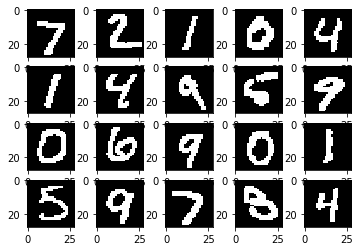

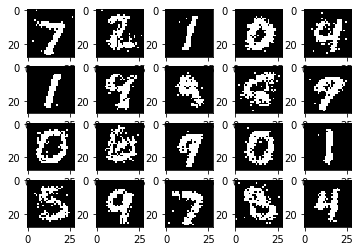

In [8]:
# Training

with tf.Session() as sess:
    
    init = tf.global_variables_initializer()
    sess.run(init)
    
    total_batch = int(mnist.train.num_examples/batch_size)    
    
    for epoch in range(num_epochs):
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            
            # 가중치 업데이트 실행 
            batch_xs = (batch_xs > 0)*1
            _ = sess.run([train_op], feed_dict={x:batch_xs})
            
        if (epoch+1) % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1))
    
    print("RBM training Completed !")
    
    # 20개의 검정용 이미지에 대해 은닉노드의 값을 계산
    out = sess.run(act_h, feed_dict={x:(mnist.test.images[:20]> 0)*1})
    label = mnist.test.labels[:20]
    
    # 20개의 실제 검정용 이미지
    plt.figure(1)
    for k in range(20):
        plt.subplot(4, 5, k+1)
        image = (mnist.test.images[k]> 0)*1
        image = np.reshape(image,(28,28))
        plt.imshow(image,cmap='gray')
        
    # 20개의 생성된 검정용 이미지
    plt.figure(2)
    for k in range(20):
        plt.subplot(4, 5, k+1)
        image = sess.run(_x, feed_dict={act_h:np.reshape(out[k],(-1,n_hidden))})
        image = np.reshape(image,(28,28))
        plt.imshow(image,cmap='gray')
        print(np.argmax(label[k]))
        
    W_out = sess.run(W)